In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from census import Census

# Census API Key
from config import api_key
c = Census(api_key, year=2009)

In [2]:
midwest_murders = pd.read_csv('MidwestMurderData.csv')
midwest_murders

,ID,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,StateName,...,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,fstate,MSA
0,197601001IA00801,"Boone, IA",IA00801,Iowa,Boone,Municipal police,FBI,No,1976,IOWA,...,Unknown or not reported,Knife or cutting instrument,Relationship not determined,Other arguments,NaN,0,0,30180.0,Iowa,Rural Iowa
1,197601001IA04400,"Henry, IA",IA04400,Iowa,Henry County,Sheriff,FBI,Yes,1976,IOWA,...,Unknown or not reported,"Handgun - pistol, revolver, etc",Acquaintance,Robbery,NaN,0,0,30180.0,Iowa,Rural Iowa
2,197601001IA05202,"Johnson, IA",IA05202,Iowa,Iowa City,Municipal police,FBI,Yes,1976,IOWA,...,Unknown or not reported,"Handgun - pistol, revolver, etc",Acquaintance,Other arguments,NaN,0,0,30180.0,Iowa,"Iowa City, IA"
3,197601001IA05701,"Linn, IA",IA05701,Iowa,Cedar Rapids,Municipal police,FBI,Yes,1976,IOWA,...,Unknown or not reported,"Handgun - pistol, revolver, etc",Husband,Other arguments,NaN,0,0,30180.0,Iowa,"Cedar Rapids, IA"
4,197601001IA05703,"Linn, IA",IA05703,Iowa,Hiawatha,Municipal police,FBI,Yes,1976,IOWA,...,Unknown or not reported,"Handgun - pistol, revolver, etc",Stranger,Brawl due to influence of alcohol,NaN,0,0,30180.0,Iowa,"Cedar Rapids, IA"
5,197601001IA06400,"Marshall, IA",IA06400,Iowa,Marshall County,Sheriff,FBI,Yes,1976,IOWA,...,Unknown or not reported,"Handgun - pistol, revolver, etc",Acquaintance,Lovers triangle,NaN,0,0,30180.0,Iowa,Rural Iowa
6,197601001IA07800,"Pottawattamie, IA",IA07800,Iowa,Pottawattamie County,Sheriff,FBI,Yes,1976,IOWA,...,Unknown or not reported,Shotgun,Stranger,Other - not specified,NaN,0,4,30180.0,Iowa,"Omaha-Council Bluffs, NE-IA"
7,197601001IL00103,"Adams, IL",IL00103,Illinois,Quincy,Municipal police,FBI,Yes,1976,ILL,...,Unknown or not reported,"Handgun - pistol, revolver, etc",Friend,Brawl due to influence of alcohol,NaN,0,1,30180.0,Illinois,Rural Illinois
8,197601001IL01000,"Champaign, IL",IL01000,Illinois,Champaign County,Sheriff,FBI,No,1976,ILL,...,Unknown or not reported,"Handgun - pistol, revolver, etc",Relationship not determined,Narcotic drug laws,NaN,0,0,30180.0,Illinois,"Champaign-Urbana, IL"
9,197601001IL01600,"Cook, IL",IL01600,Illinois,Cook County,Sheriff,FBI,Yes,1976,ILL,...,Unknown or not reported,"Handgun - pistol, revolver, etc",Stranger,Robbery,NaN,0,1,30180.0,Illinois,"Chicago-Naperville-Joliet, IL-IN-WI"


In [3]:
# From 2009 census, the same year from which MSA codes/labels in midwest_murders were taken, grab metro populations
# Filter and clean census metro data to get just the metro areas that match those in midwest_murders above

acs_msa = c.acs5.get(('NAME', 'B01003_001E'), \
                    {'for': 'metropolitan statistical area/micropolitan statistical area:*'})
acs_msa_df = pd.DataFrame(acs_msa)
acs_msa_df = acs_msa_df.rename(columns={"B01003_001E": "Population", "NAME": "MSA1",
                                  "metropolitan statistical area/micropolitan statistical area": "MSA Code"})

# Limit results to metro areas, excluding census 'micropolitan areas'
# The Murder Accountability Project processed census data through SPSS, changing MSA codes to labels
# All micropolitan MSA codes became "Rural {Statename}", with no way for users to match them back to orig codes
acs_metroonly = acs_msa_df[acs_msa_df['MSA1'].str.contains('Metro Area')]
acs_metroonly = acs_metroonly.reset_index(drop=True)

# New df with split value columns to isolate 'Metro Area'
new_metro = acs_metroonly["MSA1"].str.split(" Metro Area", n = 1, expand = True)  
# Making separate MSA column from new df 
acs_metroonly["MSA"]= new_metro[0] 
# Dropping old MSA columns 
acs_metroonly.drop(columns =["MSA1"], inplace = True) 

# New df with split columns to isolate state abbreviations
metrostates = acs_metroonly["MSA"].str.split(", ", n = 1, expand = True) 
# Add separate state column from new df
acs_metroonly['State'] = metrostates[1]

# Create list of unique values in state column to identify all possible midwest state labels in MidwestMurderData.csv
stateslist = acs_metroonly['State'].unique().tolist() 
midweststates = ['OH-PA', 'KS', 'WV-OH', 'WI', 'IA', 'OH', 'IN', 'MO', 'IL', 'IN-MI', 'SD', 'IA-NE-SD', \
                  'MO-IL', 'MO-KS', 'MN', 'MI', 'NE-IA', 'MN-WI', 'KY-IN', 'NE', 'WI-MN', 'WV-KY-OH', \
                  'ND-MN', 'AR-MO', 'IN-KY', 'IA-IL', 'OH-KY-IN', 'IL-IN-WI', 'ND']
# New df with just state values in the midweststates list, reset index 
midwest_metros = acs_metroonly[acs_metroonly['State'].isin(midweststates)]
midwest_metros = midwest_metros.reset_index(drop=True)

# Print census summary table
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(midwest_metros)

    Population MSA Code                                      MSA     State
0     571519.0    49660        Youngstown-Warren-Boardman, OH-PA     OH-PA
1     596643.0    48620                              Wichita, KS        KS
2     145942.0    48540                          Wheeling, WV-OH     WV-OH
3     122778.0    48260              Weirton-Steubenville, WV-OH     WV-OH
4     129803.0    48140                               Wausau, WI        WI
5     163040.0    47940                 Waterloo-Cedar Falls, IA        IA
6     228761.0    45820                               Topeka, KS        KS
7     673545.0    45780                               Toledo, OH        OH
8     169733.0    45460                          Terre Haute, IN        IN
9     140419.0    44220                          Springfield, OH        OH
10    417635.0    44180                          Springfield, MO        MO
11    206509.0    44100                          Springfield, IL        IL
12    316883.0    43780  

In [4]:
# Back in the midwest murder dataframe, get murder counts for each MSA
# Do this once for all murders, once for just murders in 2005-2009 (same year as our 5-year census estimates)

# Create df for 2005 through 2009 only
acs_years = [2005, 2006, 2007, 2008, 2009]
midwest_murders_0509 = midwest_murders[midwest_murders['Year'].isin(acs_years)]

# Count murders for each df
msa_murdercounts = midwest_murders.groupby(['MSA']).count().reset_index()
msa_0509_murdercounts = midwest_murders_0509.groupby(['MSA']).count().reset_index()

# Trim to necessary fields for each
msa_murdercounts = msa_murdercounts[['MSA', 'ID']]
msa_0509_murdercounts = msa_0509_murdercounts[['MSA', 'ID']]

# Remove areas derived from aggregations of all micropolitan areas in each state
msa_murdercounts = msa_murdercounts.rename(columns={'ID': 'Homicides', 'MSA': 'MSA'})
msa_murders_urban = msa_murdercounts[~msa_murdercounts['MSA'].str.contains('Rural ')]
msa_murders_urban = msa_murders_urban.reset_index(drop=True)

msa_0509_murdercounts = msa_0509_murdercounts.rename(columns={'ID': 'Homicides', 'MSA': 'MSA'})
msa_0509_murders_urban = msa_0509_murdercounts[~msa_0509_murdercounts['MSA'].str.contains('Rural ')]
msa_0509_murders_urban = msa_0509_murders_urban.reset_index(drop=True)

In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(msa_murders_urban)

                                        MSA  Homicides
0                                 Akron, OH       1132
1                                  Ames, IA         27
2                              Anderson, IN        144
3                             Ann Arbor, MI        435
4                              Appleton, WI         81
5                          Battle Creek, MI        378
6                              Bay City, MI         98
7                              Bismarck, ND         68
8                           Bloomington, IN        139
9                    Bloomington-Normal, IL         85
10                     Canton-Massillon, OH        587
11                         Cedar Rapids, IA        147
12                     Champaign-Urbana, IL        170
13      Chicago-Naperville-Joliet, IL-IN-WI      33615
14          Cincinnati-Middletown, OH-KY-IN       3314
15              Cleveland-Elyria-Mentor, OH       6828
16                             Columbia, MO        213
17        

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(msa_0509_murders_urban)

                                        MSA  Homicides
0                                 Akron, OH        145
1                                  Ames, IA          7
2                              Anderson, IN         19
3                             Ann Arbor, MI         44
4                              Appleton, WI         10
5                          Battle Creek, MI         49
6                              Bay City, MI         10
7                              Bismarck, ND         10
8                           Bloomington, IN         19
9                    Bloomington-Normal, IL          5
10                     Canton-Massillon, OH         60
11                         Cedar Rapids, IA         20
12                     Champaign-Urbana, IL          8
13      Chicago-Naperville-Joliet, IL-IN-WI       2922
14          Cincinnati-Middletown, OH-KY-IN        486
15              Cleveland-Elyria-Mentor, OH        532
16                             Columbia, MO         29
17        

In [7]:
# Add murder counts, for all years and for 2009 only, to census df with 2009 population estimates
midwest_metros = midwest_metros.sort_values('MSA').reset_index(drop=True)
midwest_metros

,Population,MSA Code,MSA,State
0,700222.0,10420,"Akron, OH",OH
1,84780.0,11180,"Ames, IA",IA
2,131015.0,11300,"Anderson, IN",IN
3,346007.0,11460,"Ann Arbor, MI",MI
4,218014.0,11540,"Appleton, WI",WI
5,136875.0,12980,"Battle Creek, MI",MI
6,107778.0,13020,"Bay City, MI",MI
7,102899.0,13900,"Bismarck, ND",ND
8,182941.0,14020,"Bloomington, IN",IN
9,163686.0,14060,"Bloomington-Normal, IL",IL


In [8]:
midwest_metromurders_p1 = pd.merge(msa_murders_urban, midwest_metros, on='MSA', how='outer')
midwest_metromurders = pd.merge(midwest_metromurders_p1, msa_0509_murders_urban, on='MSA', how='outer')

midwest_metromurders = midwest_metromurders.rename(columns={
    'MSA': 'Metro area', 'Homicides_x': 'Murders all years', 'Population': 'Population 2009', \
    'MSA Code': 'MSA Code', 'State': 'State', 'Homicides_y': 'Murders 2005-2009'
})
midwest_metromurders = midwest_metromurders.dropna()

midwest_metromurders_0509 = midwest_metromurders[['Metro area', 'Population 2009', 'Murders 2005-2009']]
midwest_metromurders_all = midwest_metromurders[['Metro area', 'Population 2009', 'Murders all years']]

In [9]:
midwest_metromurders_0509['Per capita murder rate, 2005-2009'] = midwest_metromurders_0509['Murders 2005-2009'] * 100000 / midwest_metromurders_0509['Population 2009']
midwest_metromurders_0509 = midwest_metromurders_0509.round(2).reset_index(drop=True)
midwest_metromurders_0509

/Users/matthewhanson/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Metro area,Population 2009,Murders 2005-2009,"Per capita murder rate, 2005-2009"
0,"Akron, OH",700222.0,145.0,20.71
1,"Ames, IA",84780.0,7.0,8.26
2,"Anderson, IN",131015.0,19.0,14.50
3,"Ann Arbor, MI",346007.0,44.0,12.72
4,"Appleton, WI",218014.0,10.0,4.59
5,"Battle Creek, MI",136875.0,49.0,35.80
6,"Bay City, MI",107778.0,10.0,9.28
7,"Bismarck, ND",102899.0,10.0,9.72
8,"Bloomington, IN",182941.0,19.0,10.39
9,"Bloomington-Normal, IL",163686.0,5.0,3.05


In [10]:
midwest_metromurders_0509 = midwest_metromurders_0509.set_index('Metro area')
midwest_metromurders_0509

,Population 2009,Murders 2005-2009,"Per capita murder rate, 2005-2009"
Metro area,,,
"Akron, OH",700222.0,145.0,20.71
"Ames, IA",84780.0,7.0,8.26
"Anderson, IN",131015.0,19.0,14.50
"Ann Arbor, MI",346007.0,44.0,12.72
"Appleton, WI",218014.0,10.0,4.59
"Battle Creek, MI",136875.0,49.0,35.80
"Bay City, MI",107778.0,10.0,9.28
"Bismarck, ND",102899.0,10.0,9.72
"Bloomington, IN",182941.0,19.0,10.39


Text(0, 0.5, 'Murders per 100,000 people, 2005-2009')

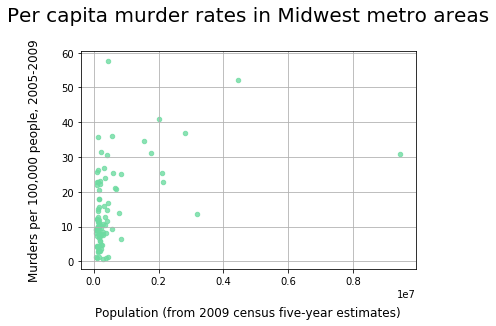

In [19]:
midwest_metromurders_0509.plot(kind='scatter', x='Population 2009', y='Per capita murder rate, 2005-2009', 
                               color='#6EDBA1', grid=True, alpha=0.8)
plt.title('Per capita murder rates in Midwest metro areas', pad=30, fontname='Chaparral Pro', fontsize=20)
plt.xlabel('Population (from 2009 census five-year estimates)', labelpad=20, fontname='Chaparral Pro', fontsize=12)
plt.ylabel('Murders per 100,000 people, 2005-2009', labelpad=20, fontname='Chaparral Pro', fontsize=12)